Test whether neg voja with recurrence can actually learn an association

In [2]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (BasicVecFeed, meg_from_spikes, numpy_bytes_to_str,
                                         gen_added_strings, norm_spa_vecs)
from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

In [3]:
with h5py.File(os.path.join(data_path, "neg_voja_weights", "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [4]:
with h5py.File(os.path.join(data_path, "neg_voja_weights", "less_base_inhib_match_weights_alt2.h5"), "r") as fi:
    
    rec_weights = np.array(fi['weights'])

In [5]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [6]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [155]:
t_pause = 0.2
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)
td_present = int(t_present/dt)

In [8]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [9]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Train

In [10]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

### Analytically

In [17]:
with nengo.Network(seed=seed) as decode_model:
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

with nengo.Simulator(decode_model) as decode_sim:
    pass

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [18]:
solver = nengo.solvers.LstsqL2(reg=0.02)

In [21]:
_, activities = tuning_curves(ens, decode_sim, inputs=np.array(feed_vecs))
init_dec, rmse = solver(activities, feed_vecs)
init_dec = init_dec.T

### With PES

In [22]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    conn_out = nengo.Connection(ens.neurons, output, transform=init_dec,
                                learning_rule_type=nengo.PES(1e-2))
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

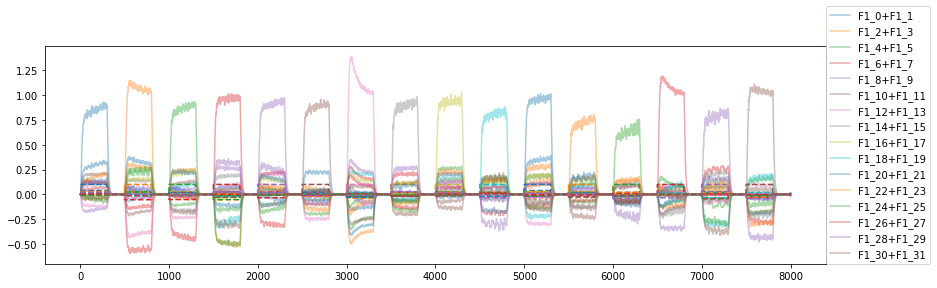

In [23]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

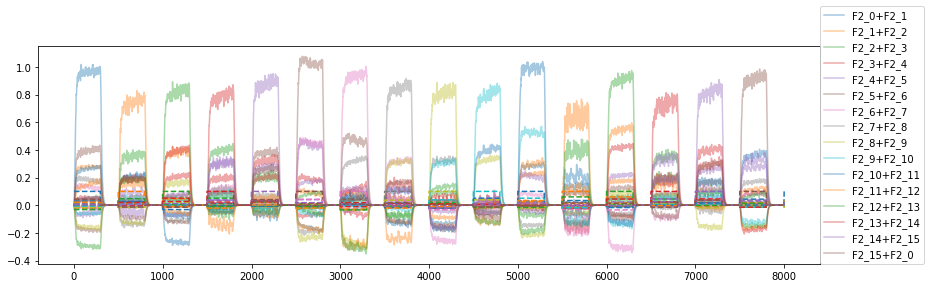

In [24]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

In [25]:
dec = learned_sim.data[p_dec][-1]
dec.shape

(32, 500)

# Test

In [221]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)
    nd_comp = nengo.Node(lambda t, x: np.dot(x[:dimensions], x[dimensions:]),
                         size_in=2*dimensions, size_out=1)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)
    nengo.Connection(ens.neurons, output, transform=dec)
    
    nengo.Connection(ens, nd_comp[:dimensions])
    nengo.Connection(correct, nd_comp[dimensions:])
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)
    p_comp = nengo.Probe(nd_comp, synapse=0.005)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

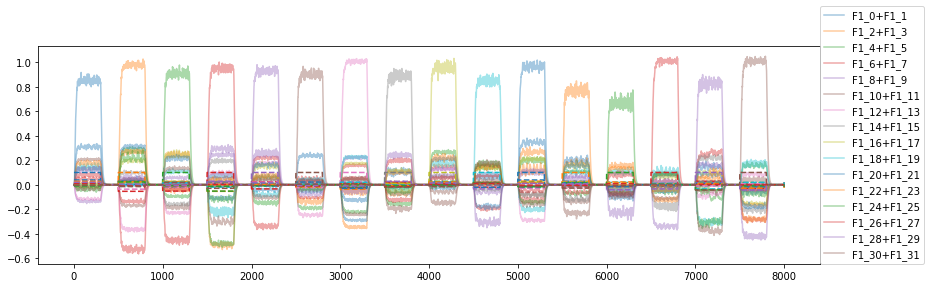

In [222]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

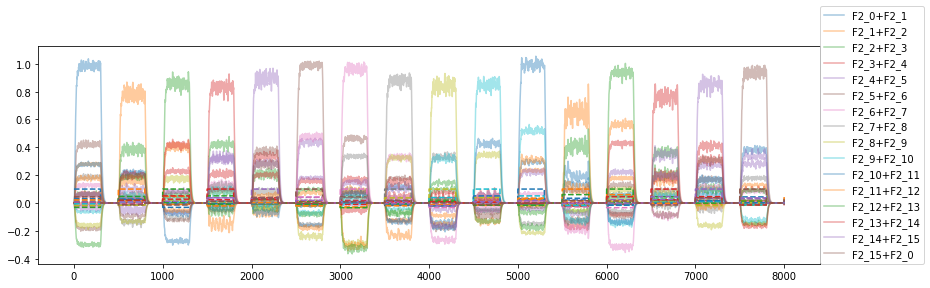

In [223]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

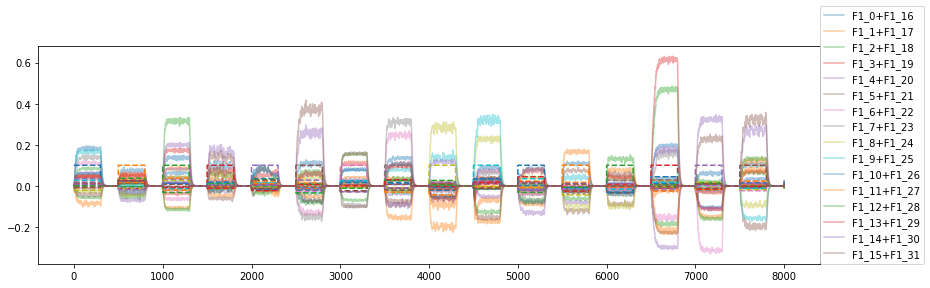

In [224]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], foil1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs)*0.1, linestyle="--")
plt.legend(foil1, loc=(1, 0))

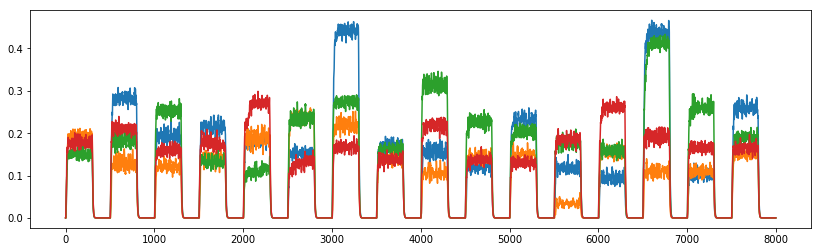

In [225]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_comp][fan1_slc])
plt.plot(test_sim.data[p_comp][fan2_slc])
plt.plot(test_sim.data[p_comp][foil1_slc])
plt.plot(test_sim.data[p_comp][foil2_slc])

## Compare accuracy

Reaction times too, but only for targets.

In [76]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [77]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [78]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[252.2151635  288.79817714 269.37874251 282.38503155 276.86755311
 269.25300007 295.50821156 263.04144807 282.09429189 250.47058336
 286.40508088 229.79324252 199.96661244 296.41939687 245.2527219
 298.59849421]
267.90298447294674


In [79]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [80]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[291.2759273  232.35830385 254.27335581 244.99125193 267.36295321
 292.77808017 285.72589915 261.30605043 250.5960092  252.14019681
 294.99877777 193.69159909 276.63728856 228.69232294 253.21869305
 277.51096167]
259.84735443473824


## Compare reaction times

In [226]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [227]:
def n_ans_conf(comp_res: np.ndarray, num_items: int, td_item: int, td_pres: int) -> np.ndarray:
    ind_ans = comp_res.reshape((td_item, num_items, -1), order='F').squeeze()
    return np.sum(ind_ans[:td_pres], axis=0)

In [230]:
neural_confs = {}
for nm, obj in slc_stim_vecs.items():
    conf_res = n_ans_conf(test_sim.data[p_comp][obj.slc], len(obj.vecs), td_each, td_present)
    neural_confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 59.44470976377898
fan2 41.77716456080828
foil1 62.163265969804
foil2 52.00936036989297


In [231]:
nconf_df = pd.DataFrame(neural_confs)

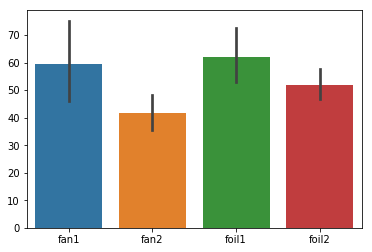

In [232]:
sns.barplot(data=nconf_df)

Learning with recurrence works fine with inital decoders. If the calculated functions is 0, learning with recurrence messes things up. Learning from function 0 only works with a really high learning rate.